In [2]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torchaudio #install pytorch in conda shell
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
from torchsummary import summary # 
import src.preprocessor as preprocessor
#plt.style.use("ggplot")
torch.manual_seed(42)

# Speech Classification Pipeline
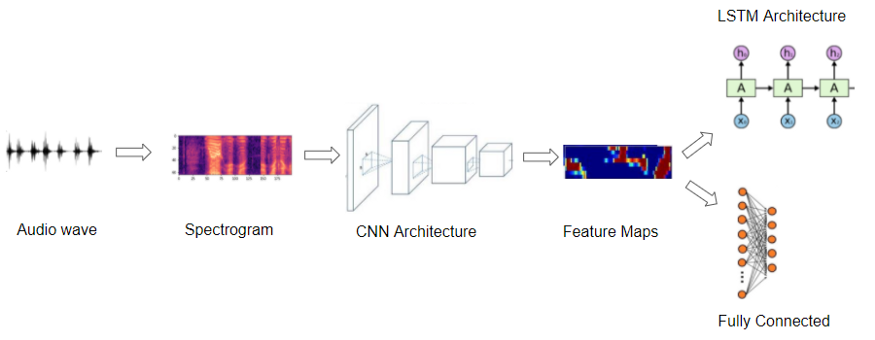

source: https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504

## Data exploration

Metadata from one recording per class

In [3]:
#accents_path = "./accentdb_extended/data" # The directory with the accent_db data
#accents_path = "C:\Users\peter\VoxPop\sample_output_directory"

accents_path="/Users/peter/VoxPop/sample_output_directory/"
os.listdir(accents_path)

['20240622_2146_ANT_features.csv',
 '20240622_2202_DUB_features.csv',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_0.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_1.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_10.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_11.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_12.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_13.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_14.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_15.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_16.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_17.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_18.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_19.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_2.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_20.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_21.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_22.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_23.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_24.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_25.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_26.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sample_27.wav',
 'ANT_Antrim_R1_F_20_Rec_0_Sam

In [ ]:
'''
for i, accent_dir in enumerate(os.listdir(accents_path)):
    dir_path = accents_path + "/" + accent_dir + "/"
    print(accent_dir)
    for file in os.listdir(dir_path):
        file_path = dir_path + file
        print(i)
        print(file_path)
        print(torchaudio.info(file_path))
        #x, sr = librosa.load("./accentdb_extended/data/bangla/bangla_s01_115.wav")
        x, sr = librosa.load(file_path)
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(y=x, sr=sr, color="b")
        plt.show()
        break
'''

## New DataFrame Handling


In [4]:
df1 = pd.read_csv(accents_path+'20240622_2202_DUB_features.csv', index_col=0)

In [5]:
df1[:3]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2
0,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,0,DUB_Artane_M_20_Rec_0_Sample_0.wav,[1.5543122e-15 3.3306691e-15 3.5527137e-15 ......,[[-45.312862 -45.312862 -20.940594 ... -33.249...,22050,[[-6.55948975e+02 -6.15149475e+02 -3.28689148e...,[[ 4.98014030e+01 4.98014030e+01 4.98014030e...,[[-3.03822708e+01 -3.03822708e+01 -3.03822708e...
1,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,1,DUB_Artane_M_20_Rec_0_Sample_1.wav,[-0.00864444 -0.01465759 -0.01211023 ... -0.01...,[[-34.0381 -32.152866 -36.18184 ... -32.387...,22050,[[-2.80546082e+02 -2.19322815e+02 -2.17854294e...,[[ 1.66335621e+01 1.66335621e+01 1.66335621e...,[[-3.09679580e+00 -3.09679580e+00 -3.09679580e...
2,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,2,DUB_Artane_M_20_Rec_0_Sample_2.wav,[-0.0135915 -0.00956258 -0.00345736 ... 0.01...,[[-26.495678 -26.199865 -34.241257 ... -36.368...,22050,[[-3.34690186e+02 -3.00306305e+02 -2.89808411e...,[[ 5.43788815e+00 5.43788815e+00 5.43788815e...,[[-1.31823075e+00 -1.31823075e+00 -1.31823075e...


In [6]:
df2 = pd.read_csv(accents_path+'20240622_2146_ANT_features.csv', index_col=0)

In [7]:
df2[:3]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2
0,C:\Users\peter\VoxPop\ANT\ANT_Antrim_R1_F_20.wav,ANT_Antrim_R1_F_20,ANT,Antrim,R,1.0,F,20,95.95,0,0,ANT_Antrim_R1_F_20_Rec_0_Sample_0.wav,[-3.2596290e-09 -1.9790605e-09 -1.8626451e-09 ...,[[-35.601192 -23.076942 -25.175114 ... -27.925...,22050,[[-4.94363190e+02 -3.14765869e+02 -2.56520905e...,[[ 2.25450897e+01 2.25450897e+01 2.25450897e...,[[-1.33637514e+01 -1.33637514e+01 -1.33637514e...
1,C:\Users\peter\VoxPop\ANT\ANT_Antrim_R1_F_20.wav,ANT_Antrim_R1_F_20,ANT,Antrim,R,1.0,F,20,95.95,0,1,ANT_Antrim_R1_F_20_Rec_0_Sample_1.wav,[-0.06371997 0.01859411 0.04244079 ... 0.00...,[[-24.939114 -19.037073 -35.540073 ... -29....,22050,[[-2.00872665e+02 -1.89228134e+02 -2.05934250e...,[[ 1.72639978e+00 1.72639978e+00 1.72639978e...,[[ 8.44261360e+00 8.44261360e+00 8.44261360e...
2,C:\Users\peter\VoxPop\ANT\ANT_Antrim_R1_F_20.wav,ANT_Antrim_R1_F_20,ANT,Antrim,R,1.0,F,20,95.95,0,2,ANT_Antrim_R1_F_20_Rec_0_Sample_2.wav,[-0.0095884 -0.02918414 -0.02309626 ... -0.03...,[[-12.003866 -22.771717 -25.912066 ... -38....,22050,[[-2.69995789e+02 -2.09718552e+02 -1.99997101e...,[[ 7.18804741e+00 7.18804741e+00 7.18804741e...,[[-7.41261578e+00 -7.41261578e+00 -7.41261578e...


In [29]:
recordings1=df1['recording num'].max()
recordings1

166

In [9]:
df2['recording num']

0        0
1        0
2        0
3        0
4        0
        ..
6489    65
6490    65
6491    65
6492    65
6493    65
Name: recording num, Length: 6494, dtype: int64

In [10]:
#Increase the recording number in the 2nd dataframe so that there are no duplicates
df2['recording num']=df2['recording num']+recordings1
df2['recording num']

0       166
1       166
2       166
3       166
4       166
       ... 
6489    231
6490    231
6491    231
6492    231
6493    231
Name: recording num, Length: 6494, dtype: int64

In [11]:
# Concatenate the DataFrames
input_df = pd.concat([df1, df2])

In [30]:
input_df.shape

(21594, 19)

In [31]:
input_df = input_df.reset_index(drop=True)

In [32]:
input_df['recording num']

0          0
1          0
2          0
3          0
4          0
        ... 
21589    231
21590    231
21591    231
21592    231
21593    231
Name: recording num, Length: 21594, dtype: int64

In [33]:
input_df[:5]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2,class_id
0,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,0,DUB_Artane_M_20_Rec_0_Sample_0.wav,[1.5543122e-15 3.3306691e-15 3.5527137e-15 ......,[[-45.312862 -45.312862 -20.940594 ... -33.249...,22050,[[-6.55948975e+02 -6.15149475e+02 -3.28689148e...,[[ 4.98014030e+01 4.98014030e+01 4.98014030e...,[[-3.03822708e+01 -3.03822708e+01 -3.03822708e...,0
1,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,1,DUB_Artane_M_20_Rec_0_Sample_1.wav,[-0.00864444 -0.01465759 -0.01211023 ... -0.01...,[[-34.0381 -32.152866 -36.18184 ... -32.387...,22050,[[-2.80546082e+02 -2.19322815e+02 -2.17854294e...,[[ 1.66335621e+01 1.66335621e+01 1.66335621e...,[[-3.09679580e+00 -3.09679580e+00 -3.09679580e...,0
2,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,2,DUB_Artane_M_20_Rec_0_Sample_2.wav,[-0.0135915 -0.00956258 -0.00345736 ... 0.01...,[[-26.495678 -26.199865 -34.241257 ... -36.368...,22050,[[-3.34690186e+02 -3.00306305e+02 -2.89808411e...,[[ 5.43788815e+00 5.43788815e+00 5.43788815e...,[[-1.31823075e+00 -1.31823075e+00 -1.31823075e...,0
3,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,3,DUB_Artane_M_20_Rec_0_Sample_3.wav,[0.01262519 0.01996171 0.02532474 ... 0.006640...,[[-24.227428 -26.599072 -47.74459 ... -36....,22050,[[-2.29787048e+02 -2.04622086e+02 -2.29607895e...,[[ 1.60471392e+00 1.60471392e+00 1.60471392e...,[[-4.01455164e+00 -4.01455164e+00 -4.01455164e...,0
4,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,4,DUB_Artane_M_20_Rec_0_Sample_4.wav,[ 0.00343075 -0.00091377 -0.00444303 ... -0.01...,[[-14.608098 -19.742035 -22.976656 ... -8.685...,22050,[[-3.32361755e+02 -2.94212708e+02 -2.60094482e...,[[ 2.11424866e+01 2.11424866e+01 2.11424866e...,[[-7.55291128e+00 -7.55291128e+00 -7.55291128e...,0


## Initial Data Analysis and Data Cleaning

In [34]:
input_df['counties'].value_counts()

counties
DUB       15100
ANTBEL     6494
Name: count, dtype: int64

The observations will be separated by geographic origin by county, the Belfast and Antrim observations will be one class, Dublin another

Merge BEL and ANT with a common county value 

In [35]:
input_df['counties'] = input_df['counties'].replace({'ANT': 'ANTBEL', 'BEL': 'ANTBEL'})

In [36]:
input_df['counties'].value_counts()

counties
DUB       15100
ANTBEL     6494
Name: count, dtype: int64

In [37]:
num_antbel=(input_df['counties']=='ANTBEL').sum()
num_antbel

6494

In [38]:
num_dub=(input_df['counties']=='DUB').sum()
num_dub

15100

Calculate the weights, the proportion of the total accounted for by each class

In [39]:
weight_dub=num_dub/(num_dub+num_antbel)
weight_dub

0.6992683152727609

In [40]:
weight_antbel=num_antbel/(num_dub+num_antbel)
weight_antbel

0.30073168472723905

In [41]:
class_weights = torch.tensor([weight_dub, weight_antbel],dtype=torch.float)
class_weights

tensor([0.6993, 0.3007])

Create a binary class marker also

In [42]:
mapping = {'DUB': 0, 'ANTBEL': 1}
input_df['class_id'] = input_df['counties'].map(mapping)

In [43]:
input_df[:3]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2,class_id
0,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,0,DUB_Artane_M_20_Rec_0_Sample_0.wav,[1.5543122e-15 3.3306691e-15 3.5527137e-15 ......,[[-45.312862 -45.312862 -20.940594 ... -33.249...,22050,[[-6.55948975e+02 -6.15149475e+02 -3.28689148e...,[[ 4.98014030e+01 4.98014030e+01 4.98014030e...,[[-3.03822708e+01 -3.03822708e+01 -3.03822708e...,0
1,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,1,DUB_Artane_M_20_Rec_0_Sample_1.wav,[-0.00864444 -0.01465759 -0.01211023 ... -0.01...,[[-34.0381 -32.152866 -36.18184 ... -32.387...,22050,[[-2.80546082e+02 -2.19322815e+02 -2.17854294e...,[[ 1.66335621e+01 1.66335621e+01 1.66335621e...,[[-3.09679580e+00 -3.09679580e+00 -3.09679580e...,0
2,C:\Users\peter\VoxPop\DUB\DUB_Artane_M_20.wav,DUB_Artane_M_20,DUB,Artane,NaN,NaN,M,20,81.63,0,2,DUB_Artane_M_20_Rec_0_Sample_2.wav,[-0.0135915 -0.00956258 -0.00345736 ... 0.01...,[[-26.495678 -26.199865 -34.241257 ... -36.368...,22050,[[-3.34690186e+02 -3.00306305e+02 -2.89808411e...,[[ 5.43788815e+00 5.43788815e+00 5.43788815e...,[[-1.31823075e+00 -1.31823075e+00 -1.31823075e...,0


Count the numbers of male and female speakers in the sample recordings

In [44]:
input_df['genders'][input_df['genders']=='M'].count()

11948

In [45]:
input_df['genders'][input_df['genders']=='F'].count()

9646

In [46]:
input_df[-4:-1]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2,class_id
21590,C:\Users\peter\VoxPop\ANT\BEL_Whitehouse_M_20_...,BEL_Whitehouse_M_20_(13),ANTBEL,Whitehouse,NaN,NaN,M,20,100.34,231,96,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_96.wav,[ 0.02460152 0.01588812 0.00461987 ... 0.00...,[[ -4.803353 -11.617571 -29.300434 ... -48....,22050,[[-3.01182892e+02 -2.77056152e+02 -2.26865936e...,[[ 1.06781569e+01 1.06781569e+01 1.06781569e...,[[-7.99286461e+00 -7.99286461e+00 -7.99286461e...,1
21591,C:\Users\peter\VoxPop\ANT\BEL_Whitehouse_M_20_...,BEL_Whitehouse_M_20_(13),ANTBEL,Whitehouse,NaN,NaN,M,20,100.34,231,97,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_97.wav,[-0.00237683 -0.00117592 -0.00169209 ... 0.05...,[[-20.16156 -26.001833 -25.968048 ... -25.360...,22050,[[-3.59239716e+02 -3.24389343e+02 -3.12734009e...,[[ 3.50342774e+00 3.50342774e+00 3.50342774e...,[[-4.29514217e+00 -4.29514217e+00 -4.29514217e...,1
21592,C:\Users\peter\VoxPop\ANT\BEL_Whitehouse_M_20_...,BEL_Whitehouse_M_20_(13),ANTBEL,Whitehouse,NaN,NaN,M,20,100.34,231,98,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_98.wav,[ 0.02828757 0.00067838 -0.03543036 ... 0.00...,[[-12.030594 -17.107288 -25.980743 ... -33.001...,22050,[[-2.15845810e+02 -2.13880249e+02 -2.44973221e...,[[-8.78343201e+00 -8.78343201e+00 -8.78343201e...,[[ 4.65423441e+00 4.65423441e+00 4.65423441e...,1


In [47]:
# create a dataframe from the input dataframes
df = pd.DataFrame(input_df[['sample file name','class_id','counties','recording num']])

In [48]:
df = df.rename(columns={'sample file name': 'file_path', 'class_id': 'class_id', 'counties': 'class_name'})

In [49]:
df

,file_path,class_id,class_name,recording num
0,DUB_Artane_M_20_Rec_0_Sample_0.wav,0,DUB,0
1,DUB_Artane_M_20_Rec_0_Sample_1.wav,0,DUB,0
2,DUB_Artane_M_20_Rec_0_Sample_2.wav,0,DUB,0
3,DUB_Artane_M_20_Rec_0_Sample_3.wav,0,DUB,0
4,DUB_Artane_M_20_Rec_0_Sample_4.wav,0,DUB,0
...,...,...,...,...
21589,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_95.wav,1,ANTBEL,231
21590,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_96.wav,1,ANTBEL,231
21591,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_97.wav,1,ANTBEL,231
21592,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_98.wav,1,ANTBEL,231


In [ ]:
'''
# create a dataframe for further usage

rows = []
for i, file in enumerate(os.listdir(accents_path)):
    if file.endswith(".wav"):
        rows.append(["/" + accents_path + file, i, accent_dir])
    else:
        continue
    
    wav_files = [file for file in files_in_directory if file.endswith('.csv')]
    for file in os.listdir(dir_path):
        rows.append(["/" + accent_dir + "/" + file, i, accent_dir])

df = pd.DataFrame(rows, columns=["file_path", "class_id", "class_name"])
df.head(10)
'''

In [50]:
df.shape

(21594, 4)

## Data preprocessing

In [51]:
class SpeechDataset(Dataset):
    def __init__(self, data_fr, data_path):
        self.data_fr = data_fr
        self.data_path = str(data_path)
  
    def __len__(self):
        return len(self.data_fr)

    def __getitem__(self, idx):
        audio_file = self.data_path + self.data_fr.loc[idx, "file_path"]
        class_id = self.data_fr.loc[idx, "class_id"]
        aud = preprocessor.load_audio(audio_file)
        rechannel = preprocessor.double_channel(aud)
        downsampl = preprocessor.downsample(rechannel)
        timed = preprocessor.append_trunc(downsampl)
        specgram = preprocessor.spectro_mfcc(timed)
        return specgram, class_id

In [52]:
num_f=(input_df['genders']=='F').sum()
df_f=input_df[input_df['genders']=='F']
num_f

9646

In [54]:
num_m=(input_df['genders']=='M').sum()
df_m=input_df[input_df['genders']=='M']
num_m

11948

In [55]:
df_f.shape

(9646, 19)

In [56]:
np.sort(df_f['recording num'].unique())

array([  3,   4,   5,   8,   9,  10,  11,  12,  13,  18,  19,  20,  25,
        26,  27,  29,  31,  35,  36,  37,  39,  40,  41,  42,  44,  45,
        46,  50,  51,  53,  55,  56,  57,  58,  61,  62,  63,  64,  69,
        73,  76,  77,  82,  83,  84,  86,  87,  91,  92,  93,  95,  96,
        98, 100, 102, 103, 107, 108, 109, 112, 113, 114, 115, 116, 122,
       123, 124, 125, 129, 130, 131, 134, 136, 137, 138, 141, 142, 151,
       152, 153, 154, 157, 158, 159, 160, 164, 166, 169, 175, 176, 180,
       181, 183, 185, 186, 192, 193, 195, 196, 198, 199, 205, 206, 207,
       208, 216, 217, 218], dtype=int64)

In [57]:
df_f['recording num'].unique().shape[0]

108

In [58]:
np.sort(df_m['recording num'].unique())

array([  0,   1,   2,   6,   7,  14,  15,  16,  17,  21,  22,  23,  24,
        28,  30,  32,  33,  34,  38,  43,  47,  48,  49,  52,  54,  59,
        60,  65,  66,  67,  68,  70,  71,  72,  74,  75,  78,  79,  80,
        81,  85,  88,  89,  90,  94,  97,  99, 101, 104, 105, 106, 110,
       111, 117, 118, 119, 120, 121, 126, 127, 128, 132, 133, 135, 139,
       140, 143, 144, 145, 146, 147, 148, 149, 150, 155, 156, 161, 162,
       163, 165, 167, 168, 170, 171, 172, 173, 174, 177, 178, 179, 182,
       184, 187, 188, 189, 190, 191, 194, 197, 200, 201, 202, 203, 204,
       209, 210, 211, 212, 213, 214, 215, 219, 220, 221, 222, 223, 224,
       225, 226, 227, 228, 229, 230, 231], dtype=int64)

In [59]:
df_m['recording num'].unique().shape[0]

124

In [60]:
input_df[input_df['recording num']==5]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2,class_id
442,C:\Users\peter\VoxPop\DUB\DUB_Ballinteer_F_20_...,DUB_Ballinteer_F_20_(3),DUB,Ballinteer,NaN,NaN,F,20,98.43,5,0,DUB_Ballinteer_F_20_(3)_Rec_5_Sample_0.wav,[ 3.9031278e-18 6.9388939e-18 3.9031278e-18 ...,[[-34.160736 -34.160736 -34.160736 ... -34.160...,22050,[[-5.43981628e+02 -5.43981628e+02 -4.74014954e...,[[ 2.59920673e+01 2.59920673e+01 2.59920673e...,[[-1.11612883e+01 -1.11612883e+01 -1.11612883e...,0
443,C:\Users\peter\VoxPop\DUB\DUB_Ballinteer_F_20_...,DUB_Ballinteer_F_20_(3),DUB,Ballinteer,NaN,NaN,F,20,98.43,5,1,DUB_Ballinteer_F_20_(3)_Rec_5_Sample_1.wav,[-0.08242799 -0.0903963 -0.0868418 ... 0.04...,[[-34.217854 -21.123123 -19.704548 ... -16....,22050,[[-2.09473175e+02 -2.12259995e+02 -2.43404068e...,[[-4.38259602e+00 -4.38259602e+00 -4.38259602e...,[[-8.44535542e+00 -8.44535542e+00 -8.44535542e...,0
444,C:\Users\peter\VoxPop\DUB\DUB_Ballinteer_F_20_...,DUB_Ballinteer_F_20_(3),DUB,Ballinteer,NaN,NaN,F,20,98.43,5,2,DUB_Ballinteer_F_20_(3)_Rec_5_Sample_2.wav,[ 0.03617488 0.02190169 0.00397988 ... -0.07...,[[ 7.040368 11.601768 -4.4614105 ... -24....,22050,[[-1.96496445e+02 -1.68154144e+02 -1.88246857e...,[[-3.31156654e+01 -3.31156654e+01 -3.31156654e...,[[-8.16862345e-01 -8.16862345e-01 -8.16862345e...,0
445,C:\Users\peter\VoxPop\DUB\DUB_Ballinteer_F_20_...,DUB_Ballinteer_F_20_(3),DUB,Ballinteer,NaN,NaN,F,20,98.43,5,3,DUB_Ballinteer_F_20_(3)_Rec_5_Sample_3.wav,[-0.07683568 -0.07583623 -0.07926324 ... 0.02...,[[ -8.871327 -13.627343 -24.220161 ... -36.909...,22050,[[-2.78214661e+02 -2.99813995e+02 -2.76307983e...,[[-4.04774994e-02 -4.04774994e-02 -4.04774994e...,[[-4.25276661e+00 -4.25276661e+00 -4.25276661e...,0
446,C:\Users\peter\VoxPop\DUB\DUB_Ballinteer_F_20_...,DUB_Ballinteer_F_20_(3),DUB,Ballinteer,NaN,NaN,F,20,98.43,5,4,DUB_Ballinteer_F_20_(3)_Rec_5_Sample_4.wav,[ 0.00192947 0.00828893 0.00013423 ... -0.00...,[[-38.503456 -25.950909 -23.000187 ... -29.148...,22050,[[-2.95450378e+02 -2.48088699e+02 -2.64537140e...,[[-1.01710105e+00 -1.01710105e+00 -1.01710105e...,[[-7.06527662e+00 -7.06527662e+00 -7.06527662e...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,C:\Users\peter\VoxPop\DUB\DUB_Ballinteer_F_20_...,DUB_Ballinteer_F_20_(3),DUB,Ballinteer,NaN,NaN,F,20,98.43,5,93,DUB_Ballinteer_F_20_(3)_Rec_5_Sample_93.wav,[-0.01465604 -0.01641628 -0.01627423 ... 0.00...,[[-1.1280799e+01 -2.7772106e+01 -2.7039723e+00...,22050,[[-2.99837860e+02 -2.26946320e+02 -1.98246033e...,[[-9.92961788e+00 -9.92961788e+00 -9.92961788e...,[[-4.10027170e+00 -4.10027170e+00 -4.10027170e...,0
536,C:\Users\peter\VoxPop\DUB\DUB_Ballinteer_F_20_...,DUB_Ballinteer_F_20_(3),DUB,Ballinteer,NaN,NaN,F,20,98.43,5,94,DUB_Ballinteer_F_20_(3)_Rec_5_Sample_94.wav,[ 0.00280385 0.00287095 0.00456078 ... 0.00...,[[-29.87461 -28.735374 -16.747526 ... -31.686...,22050,[[-4.36241333e+02 -4.08011047e+02 -4.10060699e...,[[ 6.00202417e+00 6.00202417e+00 6.00202417e...,[[-2.57755470e+00 -2.57755470e+00 -2.57755470e...,0
537,C:\Users\peter\VoxPop\DUB\DUB_Ballinteer_F_20_...,DUB_Ballinteer_F_20_(3),DUB,Ballinteer,NaN,NaN,F,20,98.43,5,95,DUB_Ballinteer_F_20_(3)_Rec_5_Sample_95.wav,[0.00089394 0.00049466 0.0029246 ... 0.158148...,[[-28.15521 -27.282707 -30.020884 ... -25....,22050,[[-4.25207367e+02 -3.51026978e+02 -3.11428009e...,[[ 2.32724037e+01 2.32724037e+01 2.32724037e...,[[-1.13502512e+01 -1.13502512e+01 -1.13502512e...,0
538,C:\Users\peter\VoxPop\DUB\DUB_Ballinteer_F_20_...,DUB_Ballinteer_F_20_(3),DUB,Ballinteer,NaN,NaN,F,20,98.43,5,96,DUB_Ballinteer_F_20_(3)_Rec_5_Sample_96.wav,[ 0.2641878 0.30334672 0.3274039 ... -0.00...,[[ 8.238987 2.4613662 -31.796682 ... -21....,22050,[[-1.46237885e+02 -1.70286240e+02 -2.08756958e...,[[-6.89117813e+00 -6.89117813e+00 -6.89117813e...,[[ 3.51630306e+00 3.51630306e+00 3.51630306e...,0


In [61]:
df_m.shape

(11948, 19)

In [ ]:
#Select either the male or the female subset of samples only
#df=df_m
#df=df_f

In [63]:
df=df.reset_index(drop=True)

In [64]:
df

,file_path,class_id,class_name,recording num
0,DUB_Artane_M_20_Rec_0_Sample_0.wav,0,DUB,0
1,DUB_Artane_M_20_Rec_0_Sample_1.wav,0,DUB,0
2,DUB_Artane_M_20_Rec_0_Sample_2.wav,0,DUB,0
3,DUB_Artane_M_20_Rec_0_Sample_3.wav,0,DUB,0
4,DUB_Artane_M_20_Rec_0_Sample_4.wav,0,DUB,0
...,...,...,...,...
21589,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_95.wav,1,ANTBEL,231
21590,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_96.wav,1,ANTBEL,231
21591,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_97.wav,1,ANTBEL,231
21592,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_98.wav,1,ANTBEL,231


## Split into train and validate datasets

In [66]:
# Select samples for training and validation by SPEAKER i.e. by recording number
# Random split of 80:20 between training and validation
num_items = df.shape[0]
num_train = round(num_items * 0.7)
num_val = num_items - num_train


In [67]:
print(num_items)
print(num_train)
print(num_val)

21594
15116
6478


In [68]:
unique_recordings = df['recording num'].unique()
np.random.shuffle(unique_recordings)  # Shuffle the unique values

# Determine the split index
split_index = int(len(unique_recordings) * 0.7)


In [70]:
df['recording num'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [71]:
unique_recordings

array([ 62,  86,  60, 104,   7, 199,  36, 117, 220,  19,  91, 183, 195,
       163,  15, 112,  76, 171, 140,  95, 135, 213,  88, 196,  71,   1,
        13, 176,  67, 153, 175, 173,  45, 210,  52,  93, 107,  97, 106,
        70,  55, 157, 218,  92, 137,  11, 180, 158, 209,  20, 127, 169,
        31, 211,  50,  46,  26, 200, 120,  58, 192,   2,  27, 223,   9,
       201, 142, 126,  83,  35,  80, 203, 102, 151,  59, 214, 159, 147,
        29, 164,  49,  51,  54,  22, 198, 186, 144, 225, 109,  82, 204,
        74, 139,  30,  96, 111, 167, 108, 207,   0,  40,  69, 162, 190,
        10,  25, 150, 184, 103,  18, 227, 172, 131,  99, 161, 138, 191,
        94, 115, 206, 141, 105, 168, 222, 178,  81, 182, 125,  28,  89,
        32, 101, 230,  64,  43, 136,  61,  78,  66,  47, 146,  84, 226,
        39,  63, 216,  34,  24, 221, 229, 188, 217, 124, 100, 134,   4,
       189,  21, 224, 219,  85,   3,  98, 177, 128, 160,  73,  12, 212,
       156,   5,   8,  72, 179, 149,  38, 194, 228,  41,  17,  2

In [72]:
unique_recordings.shape

(232,)

In [74]:
unique_recordings.max()

231

In [80]:
unique_recordings[:split_index]

array([ 62,  86,  60, 104,   7, 199,  36, 117, 220,  19,  91, 183, 195,
       163,  15, 112,  76, 171, 140,  95, 135, 213,  88, 196,  71,   1,
        13, 176,  67, 153, 175, 173,  45, 210,  52,  93, 107,  97, 106,
        70,  55, 157, 218,  92, 137,  11, 180, 158, 209,  20, 127, 169,
        31, 211,  50,  46,  26, 200, 120,  58, 192,   2,  27, 223,   9,
       201, 142, 126,  83,  35,  80, 203, 102, 151,  59, 214, 159, 147,
        29, 164,  49,  51,  54,  22, 198, 186, 144, 225, 109,  82, 204,
        74, 139,  30,  96, 111, 167, 108, 207,   0,  40,  69, 162, 190,
        10,  25, 150, 184, 103,  18, 227, 172, 131,  99, 161, 138, 191,
        94, 115, 206, 141, 105, 168, 222, 178,  81, 182, 125,  28,  89,
        32, 101, 230,  64,  43, 136,  61,  78,  66,  47, 146,  84, 226,
        39,  63, 216,  34,  24, 221, 229, 188, 217, 124, 100, 134,   4,
       189,  21, 224, 219,  85,   3], dtype=int64)

In [81]:
unique_recordings[:split_index].shape[0]

162

In [82]:
unique_recordings[split_index:]

array([ 98, 177, 128, 160,  73,  12, 212, 156,   5,   8,  72, 179, 149,
        38, 194, 228,  41,  17,  23, 123, 122,  56,  42, 129,  68, 187,
        75,  53, 119, 113,  90,  16, 202,  87, 143, 155, 170, 185, 114,
        44, 116, 165,  14, 231, 174,  79, 145, 154, 181, 133, 121, 215,
        57,  48, 166, 205, 193, 152, 110,  65,  37, 130, 132, 118, 148,
       208,  77,   6, 197,  33], dtype=int64)

In [79]:
unique_recordings[split_index:].shape[0]

70

In [83]:
# Split the unique values into two sets (70% and 30%)
recording_train = unique_recordings[:split_index]
recording_val = unique_recordings[split_index:]

# Create two new DataFrames based on the split unique values
df_train = df[df['recording num'].isin(recording_train)].reset_index(drop=True)
df_val = df[df['recording num'].isin(recording_val)].reset_index(drop=True)

In [84]:
df_train.shape

(15020, 4)

In [85]:
df_train['recording num'].unique()

array([  0,   1,   2,   3,   4,   7,   9,  10,  11,  13,  15,  18,  19,
        20,  21,  22,  24,  25,  26,  27,  28,  29,  30,  31,  32,  34,
        35,  36,  39,  40,  43,  45,  46,  47,  49,  50,  51,  52,  54,
        55,  58,  59,  60,  61,  62,  63,  64,  66,  67,  69,  70,  71,
        74,  76,  78,  80,  81,  82,  83,  84,  85,  86,  88,  89,  91,
        92,  93,  94,  95,  96,  97,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 111, 112, 115, 117, 120, 124, 125, 126, 127,
       131, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 146, 147,
       150, 151, 153, 157, 158, 159, 161, 162, 163, 164, 167, 168, 169,
       171, 172, 173, 175, 176, 178, 180, 182, 183, 184, 186, 188, 189,
       190, 191, 192, 195, 196, 198, 199, 200, 201, 203, 204, 206, 207,
       209, 210, 211, 213, 214, 216, 217, 218, 219, 220, 221, 222, 223,
       224, 225, 226, 227, 229, 230], dtype=int64)

In [86]:
df_train['recording num'].unique().shape

(162,)

In [87]:
df_val.shape

(6574, 4)

In [88]:
df_val['recording num'].unique()

array([  5,   6,   8,  12,  14,  16,  17,  23,  33,  37,  38,  41,  42,
        44,  48,  53,  56,  57,  65,  68,  72,  73,  75,  77,  79,  87,
        90,  98, 110, 113, 114, 116, 118, 119, 121, 122, 123, 128, 129,
       130, 132, 133, 143, 145, 148, 149, 152, 154, 155, 156, 160, 165,
       166, 170, 174, 177, 179, 181, 185, 187, 193, 194, 197, 202, 205,
       208, 212, 215, 228, 231], dtype=int64)

In [89]:
df_val['recording num'].unique().shape

(70,)

In [93]:
train_ds = SpeechDataset(df_train, accents_path)
train_dl=DataLoader(train_ds, batch_size=15, shuffle=True)

In [94]:
val_ds = SpeechDataset(df_val, accents_path)
val_dl=DataLoader(val_ds, batch_size=15, shuffle=False)

In [ ]:
'''
# Random split of 80:20 between training and validation
num_items = len(speech_dataset)
num_train = round(num_items * 0.7)
num_val = num_items - num_train
train_ds, val_ds = random_split(speech_dataset, [num_train, num_val])

# Create training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=15, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=15, shuffle=False)
'''

In [95]:
'''
# Random split of 80:20 between training and validation
num_items = len(speech_dataset)
num_train = round(num_items * 0.7)
num_val = num_items - num_train
train_ds, val_ds = random_split(speech_dataset, [num_train, num_val])
# Create training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=15, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=15, shuffle=False)
'''

'\n# Random split of 80:20 between training and validation\nnum_items = len(speech_dataset)\nnum_train = round(num_items * 0.7)\nnum_val = num_items - num_train\ntrain_ds, val_ds = random_split(speech_dataset, [num_train, num_val])\n# Create training and validation data loaders\ntrain_dl = DataLoader(train_ds, batch_size=15, shuffle=True)\nval_dl = DataLoader(val_ds, batch_size=15, shuffle=False)\n'

In [96]:
print("dataset")
print(num_items)
print("training")
print(num_train)
print("validation")
print(num_val)

dataset
21594
training
15116
validation
6478


In [97]:
train_ds

In [98]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

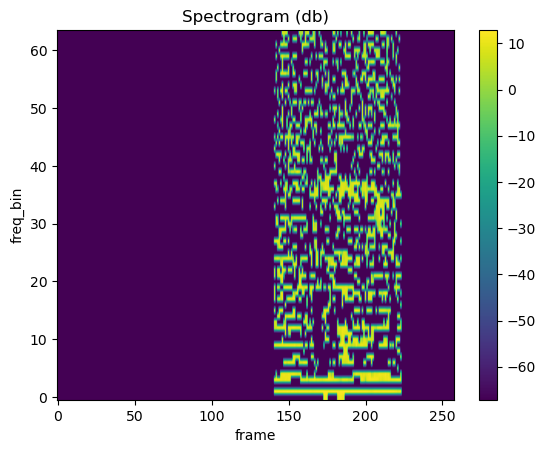

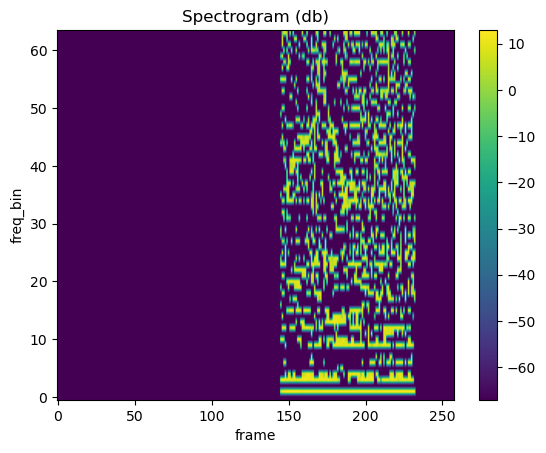

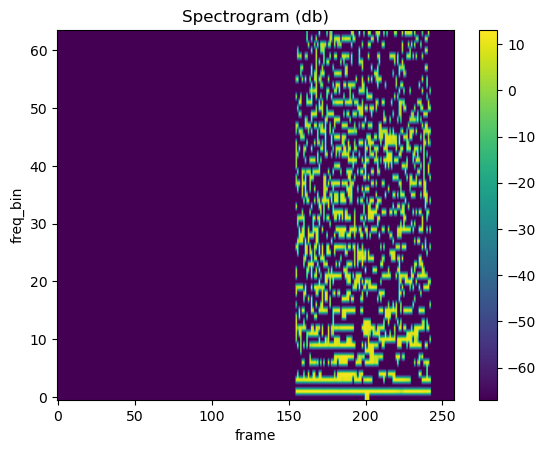

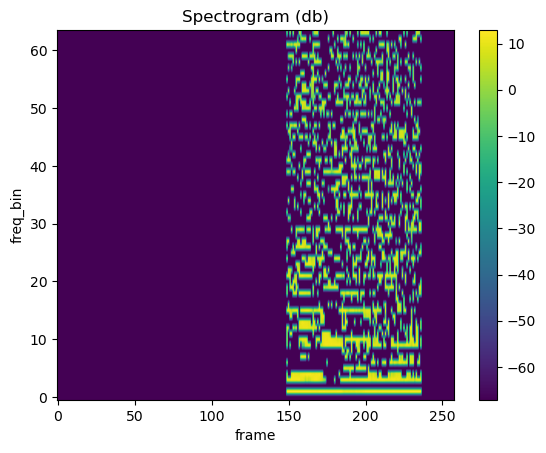

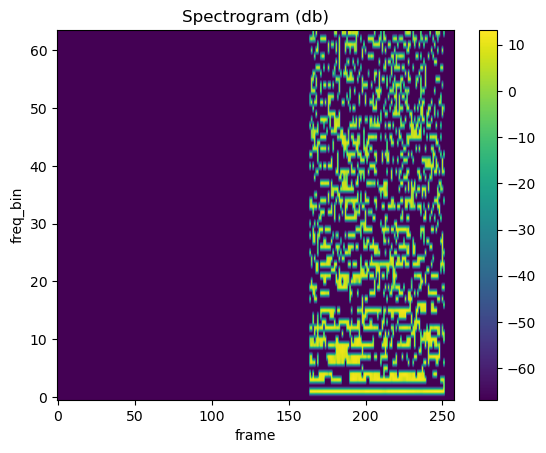

In [99]:
for i in range(5):
    plot_spectrogram(train_ds[i][0][0])

## Classifier model

In [100]:
class AudioClassifier(nn.Module):
    def __init__(self):
        super(AudioClassifier, self).__init__()
        # Wrap the Convolutional Bl~ocks
        self.conv = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.dropout = nn.Dropout(0.5)
        #self.lin = nn.Linear(in_features=32, out_features=9) #used with the 9 class classfication problem of the original accent_db paper
        self.lin = nn.Linear(in_features=32, out_features=2) #used with CrossEntropyLoss with the two classes onlyh
        #self.lin = nn.Linear(in_features=32, out_features=1)

    def forward(self, inp_x):
        inp_x = self.conv(inp_x)
        inp_x = self.ap(inp_x)
        inp_x = inp_x.view(inp_x.shape[0], -1)
        inp_x = self.dropout(inp_x)
        inp_x = self.lin(inp_x)
        return inp_x

In [101]:
class AccuracyMetric:
    def __init__(self):
        self.correct, self.total = None, None
        self.reset()

    def update(self, y_pred, y_true):
        self.correct += torch.sum(y_pred.argmax(-1) == y_true).item()
        #self.correct += torch.sum(y_pred == y_true).item()
        self.total += y_true.size(0)

    def compute(self):
        return self.correct / self.total

    def reset(self):
        self.correct = 0
        self.total = 0

## Training and Inference

In [102]:
# Create the model and put it on the GPU if available
model = AudioClassifier()
device = torch.device("cpu")
model = model.to(device)
next(model.parameters()).device
summary(model, (2, 64, 258), 11)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [11, 8, 32, 129]             152
              ReLU-2           [11, 8, 32, 129]               0
       BatchNorm2d-3           [11, 8, 32, 129]              16
            Conv2d-4           [11, 16, 16, 65]           1,168
              ReLU-5           [11, 16, 16, 65]               0
       BatchNorm2d-6           [11, 16, 16, 65]              32
            Conv2d-7            [11, 32, 8, 33]           4,640
              ReLU-8            [11, 32, 8, 33]               0
       BatchNorm2d-9            [11, 32, 8, 33]              64
AdaptiveAvgPool2d-10             [11, 32, 1, 1]               0
          Dropout-11                   [11, 32]               0
           Linear-12                    [11, 2]              66
Total params: 6,138
Trainable params: 6,138
Non-trainable params: 0
-----------------------------------

In [200]:
#criterion = torch.nn.BCELoss()
#criterion = torch.nn.CrossEntropyLoss() #original
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epochs = 5
#epochs = 10

# training loop
train_loss_history = []
train_accuracy_history = []

valid_loss_history = []
valid_accuracy_history = []

predicted=[]
actual=[]

accuracy = AccuracyMetric()

for epoch in range(1, epochs + 1):
    print(f"[INFO] Epoch: {epoch}")
    model.train()

    batch_train_loss = []
    batch_valid_loss = []

    for X_batch, y_batch in tqdm(train_dl):
        # perform single training step
        model.zero_grad()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_predicted = model(X_batch)

        loss = criterion(y_predicted, y_batch)
        #print(loss)
        loss.backward()
        optimizer.step()
        accuracy.update(y_predicted, y_batch)
        batch_train_loss.append(loss.item())

        

    mean_epoch_loss_train = np.mean(batch_train_loss)
    train_accuracy = accuracy.compute()

    train_loss_history.append(mean_epoch_loss_train)
    train_accuracy_history.append(train_accuracy)
    accuracy.reset()

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_dl):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_predicted = model(X_batch)

            loss_val = criterion(y_predicted, y_batch)

            accuracy.update(y_predicted, y_batch)
            batch_valid_loss.append(loss_val.item())

            predicted.append(y_predicted)
            actual.append(y_batch)

    mean_epoch_loss_valid = np.mean(batch_valid_loss)
    valid_accuracy = accuracy.compute()
    
    valid_loss_history.append(mean_epoch_loss_valid)
    valid_accuracy_history.append(valid_accuracy)
    accuracy.reset()

    print(
        f"Train loss: {mean_epoch_loss_train:0.4f}, Train accuracy: {train_accuracy: 0.4f}"
    )
    print(
        f"Validation loss: {mean_epoch_loss_valid:0.4f}, Validation accuracy: {valid_accuracy: 0.4f}"
    )

[INFO] Epoch: 1


100%|██████████| 439/439 [00:18<00:00, 23.92it/s]


Train loss: 0.2137, Train accuracy:  0.8745
Validation loss: 0.2966, Validation accuracy:  0.8696
[INFO] Epoch: 2


100%|██████████| 439/439 [00:19<00:00, 22.95it/s]


Train loss: 0.2165, Train accuracy:  0.8740
Validation loss: 0.2840, Validation accuracy:  0.8696
[INFO] Epoch: 3


100%|██████████| 439/439 [00:18<00:00, 23.15it/s]


Train loss: 0.2165, Train accuracy:  0.8707
Validation loss: 0.3940, Validation accuracy:  0.8372
[INFO] Epoch: 4


100%|██████████| 439/439 [00:19<00:00, 22.04it/s]


Train loss: 0.2143, Train accuracy:  0.8759
Validation loss: 0.3250, Validation accuracy:  0.8524
[INFO] Epoch: 5


100%|██████████| 439/439 [00:18<00:00, 23.64it/s]

Train loss: 0.2087, Train accuracy:  0.8788
Validation loss: 0.3033, Validation accuracy:  0.8748


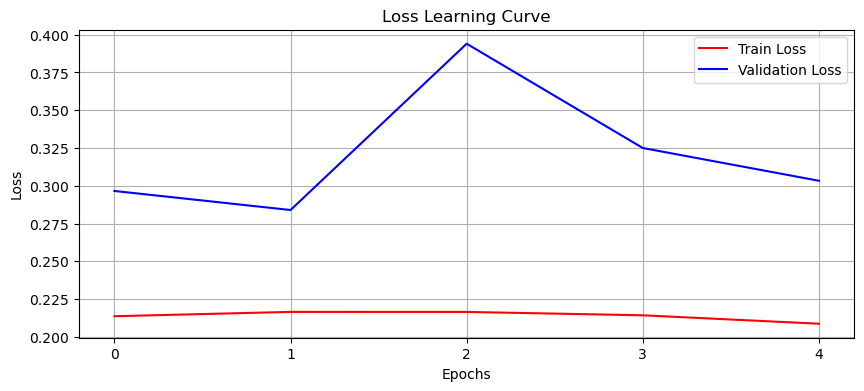

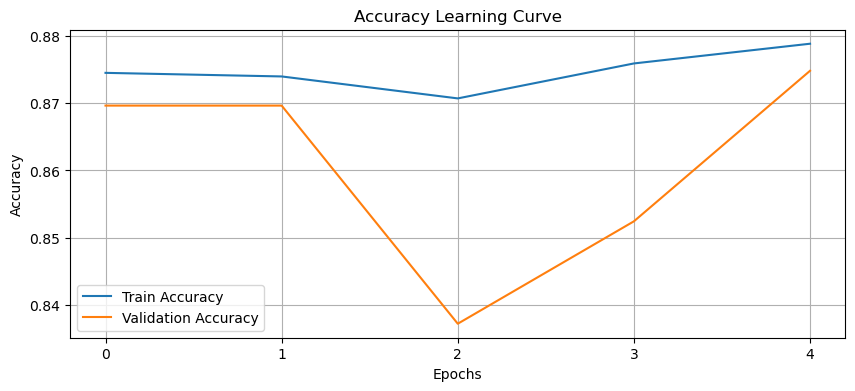

In [201]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(train_loss_history, color="r")
plt.xticks(range(epochs))
plt.plot(valid_loss_history, color="b")
plt.xticks(range(epochs))
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Learning Curve")
ax.grid(True)

fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(train_accuracy_history)
plt.xticks(range(epochs))
plt.plot(valid_accuracy_history)
plt.xticks(range
           (epochs))

plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Learning Curve")
ax.grid(True)

In [202]:
print("mean accuracy = : {:3.2%}".format(np.mean(valid_accuracy_history)))

mean accuracy = : 86.08%


In [195]:
predicted[0].argmax(-1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [193]:
predicted

[tensor([[ 2.5159, -3.2178],
         [ 2.9483, -3.4333],
         [ 4.0739, -4.8197],
         [ 2.3266, -2.8465],
         [ 2.8186, -3.2684],
         [ 2.1359, -2.5921],
         [ 3.3336, -3.8047],
         [ 3.9622, -4.5073],
         [ 2.9924, -3.6081],
         [ 1.5077, -1.6234],
         [ 4.0925, -4.7518],
         [ 4.3606, -5.0656],
         [ 2.6551, -3.2265],
         [ 2.0784, -2.4052],
         [ 3.7789, -4.6002]]),
 tensor([[ 2.5320, -2.6874],
         [ 2.5370, -2.9244],
         [ 2.5866, -2.8489],
         [ 2.1723, -2.3822],
         [ 3.3542, -3.7220],
         [ 3.4984, -3.8598],
         [ 2.6478, -3.1751],
         [ 2.7267, -3.3032],
         [ 3.9600, -4.7028],
         [ 4.3513, -5.0310],
         [ 4.3149, -4.9309],
         [ 4.1102, -4.7456],
         [ 4.5277, -5.1121],
         [ 3.5839, -4.2072],
         [ 3.8083, -4.3694]]),
 tensor([[ 4.2868, -5.0615],
         [ 2.9458, -3.2977],
         [ 4.2908, -4.7472],
         [ 3.1742, -3.8304],
         [

In [183]:
predict=[]

In [188]:
for count, i in enumerate(predicted): 
    print(coun
    predict.append(i.argmax(-1))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [196]:
predict

[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [197]:
actual

[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [198]:
len(prediction)

1002

In [199]:
len(actual)

2195

In [135]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [132]:
confmat = confusion_matrix(y_true=y_batch, y_pred=y_predicted)
print(confmat)

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

In [ ]:
X_batch.shape

In [ ]:
y_batch

In [ ]:
(y_predicted)

In [ ]:
y_predicted.argmax(-1)

In [ ]:
y_batch

In [ ]:
# Compare the tensors element-wise
matches = torch.eq(y_predicted.argmax(-1), y_batch)

# Count the number of matches
num_matches = matches.sum().item()

# Display the number of matching values
print(f'Number of matching values: {num_matches}')

In [ ]:
12/14

In [ ]:
torch.sum(y_predicted.argmax(-1) == y_batch).item()

In [ ]:
torch.sum(y_predicted.argmax(-1) == y_batch)

In [ ]:
torch.sum(y_predicted.argmax(-1) == y_batch).item()